# Co-author Network Link Prediction

Data comes from https://www.aminer.org/citation

Based on "Graphs and Machine Learning in Practice: Link Prediction" in Graph Algorithms. Practical Examples in Apache Spark and Neo4j.



In [3]:
import pandas as pd

In [6]:
import json
from py2neo import  Graph, Node
import os

In [2]:
%ls data

ads1000.csv            dbms/           transport-nodes.csv
citation-network1.zip  goodbooks-10k/  transport-relationships.csv
databases/             outputacm.txt   trump-world.csv
dblp.v10.zip           transactions/


## Loading the data

In [359]:
# making smaller sample data
file = open("data/dblp-ref/dblp-ref-3.json", "r")
os.remove("import/dblp-ref-3-small.json") 
smallfile = open("import/dblp-ref-3-small.json", "a")

In [360]:
for i in range(15000):
    line=file.readline()
    smallfile.write(line)

In [361]:
file.close()
smallfile.close()

In [362]:
print(json.dumps(json.loads(line), indent=4, sort_keys=True))

{
    "authors": [
        "Macario O. Cordel",
        "Arnulfo P. Azcarraga"
    ],
    "id": "fff8aa8d-19eb-4cdb-b45c-d93ab48f32bc",
    "n_citation": 0,
    "references": [
        "526860a6-aea8-4f8d-b7f9-e01d3629a6a9",
        "b3021ed3-42de-4b75-ad6e-bd64e51f4cba"
    ],
    "title": "Measuring the contribution of filter bank layer to performance of convolutional neural networks",
    "venue": "International Journal of Knowledge-based and Intelligent Engineering Systems",
    "year": 2017
}


## The Coauthorship Graph

https://neo4j.com/blog/cypher-load-json-from-url/

In [91]:
# create a graph
graphdb = Graph(scheme="bolt", host="localhost", port=7687, secure=False, auth=('neo4j', 'test'))
#graphdb.delete_all()

In [364]:
# https://neo4j.com/docs/labs/apoc/current/import/load-json/

graphdb.run("""CALL apoc.load.json("file:///dblp-ref-3-small.json")
YIELD value
WHERE value.venue IN ["Lecture Notes in Computer Science",
    "Communications of The ACM",
    "international conference on software engineering",
    "advances in computing and communications"]
MERGE (p:Article {title: value.title})
SET p.year = value.year
WITH p, value
UNWIND value.authors AS author
MERGE (c:Author {name: author})
MERGE (p)-[:AUTHOR_OF]->(c)
""")

In [365]:
# when we pointed authors to articles then we double counted co-authorships
graphdb.run("""MATCH (a1:Author)<-[:AUTHOR_OF]-(paper:Article)-[:AUTHOR_OF]->(a2:Author)
WITH a1,a2, paper
ORDER BY a1,paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
SET coauthor.collaborations = collaborations;""")



## Plot graph schema

https://networkx.github.io/documentation/latest/_downloads/networkx_reference.pdf

https://stackoverflow.com/questions/22312334/how-to-show-cycles-in-networkx-graph-drawing

https://pypi.org/project/graphviz/


In [53]:
import networkx as nx  
import matplotlib.pyplot as plt  
%matplotlib inline

In [212]:
G = nx.DiGraph()

In [213]:
G.add_nodes_from(["Article", "Author"])

In [214]:
G.add_edge("Article", "Author")

In [215]:
G.add_edge("Author", "Author")

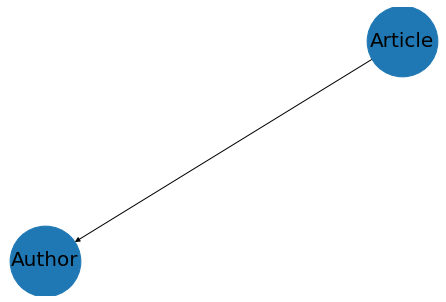

In [252]:
nx.draw(G, with_labels = True, node_size = 5000, font_size = 20)  
plt.show()  

In [240]:
# to plot self nodes need transform nx graph to pydot
# use graphviz to plot
pydot_graph = nx.drawing.nx_pydot.to_pydot(G)
pydot_graph

In [257]:
import pydot
pdot=pydot.graph_from_dot_file("graph.dot")
pdot[0]

In [ ]:
from IPython.display import Image, display

plt = Image(pdot[0].create_fig())
display(plt)

## Summary stats

https://neo4j.com/blog/data-profiling-holistic-view-neo4j/

In [366]:
print(str(graphdb.run("""MATCH (n) RETURN count(n)""").evaluate()) + " nodes")
print(str(graphdb.run("""MATCH (n:Article) RETURN count(n)""").evaluate()) + " articles")
print(str(graphdb.run("""MATCH (n:Author) RETURN count(n)""").evaluate()) + " authors")
print(str(graphdb.run("""MATCH ()-[r]->() RETURN count(*)""").evaluate()) + " relationships")

5676 nodes
1579 articles
4097 authors
10210 relationships


In [367]:
graphdb.run("""CALL db.relationshipTypes()""").to_table()

relationshipType
AUTHOR_OF
CO_AUTHOR


In [368]:
# number of co-authorship pairs
# number of co-authorship pairs per year
# number of articles per year
graphdb.run("""MATCH (n) RETURN labels(n) AS NodeType, count(n) AS NumberOfNodes""").to_table()

NodeType,NumberOfNodes
['Article'],1579
['Author'],4097


In [369]:
graphdb.run("""MATCH  ()-[r]-()
    RETURN type(r) AS RelationshipType, count(r) AS NumberOfRelationships""").to_table()

RelationshipType,NumberOfRelationships
AUTHOR_OF,9134
CO_AUTHOR,11286


In [370]:
graphdb.run("""MATCH (u:Article) RETURN keys(u) LIMIT 1""").to_table()

keys(u)
"['title', 'year']"


In [371]:
graphdb.run("""MATCH ()-[t:AUTHOR_OF]-() RETURN keys(t) LIMIT 1""").to_table()

keys(t)
[]


In [372]:
graphdb.run("""MATCH ()-[t:CO_AUTHOR]-() RETURN keys(t) LIMIT 1""").to_table()

keys(t)
"['collaborations', 'year']"


In [373]:
graphdb.run("""MATCH ()-[p:CO_AUTHOR]-()
    RETURN min(p.collaborations) AS MinCollaborations, 
    max(p.collaborations) AS MaxCollaborations, 
    avg(p.collaborations) AS AvgCollaborations, 
    stDev(p.collaborations) AS StdCollaborations""").to_table()

MinCollaborations,MaxCollaborations,AvgCollaborations,StdCollaborations
1,6,1.0241006556795988,0.18481201975399456


In [374]:
graphdb.run("""MATCH ()-[p:CO_AUTHOR]-()
    RETURN p.collaborations, count(p.collaborations) AS total
    ORDER BY p.collaborations""").to_table()

p.collaborations,total
1,11050
2,214
3,16
5,4
6,2


## Splitting into training and test set

In [385]:
articles=graphdb.run("""MATCH (a:Article)
    RETURN a.year AS year, count(a.year) AS totalArticles
    ORDER BY year""").to_data_frame()
    

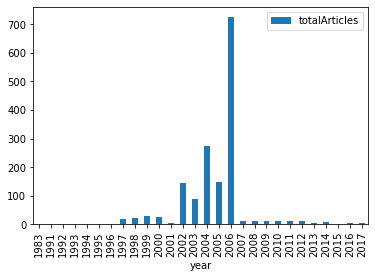

In [389]:
articles.plot("year","totalArticles", kind="bar")

In [377]:
graphdb.run("""MATCH (a:Article)
    RETURN a.year < 2006 AS training, count(*) AS count""").to_table()

training,count
false,817
true,762


In [392]:
# Create relationship CO_AUTHOR_EARLY for co author pairs before 2006
graphdb.run("""MATCH (a1)<-[:AUTHOR_OF]-(paper:Article)-[:AUTHOR_OF]->(a2:Author)
    WITH a1, a2, paper
    ORDER BY a1, paper.year
    WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
    WHERE year < 2006
    MERGE (a1)-[coauthor:CO_AUTHOR_EARLY {year: year}]-(a2)
    SET coauthor.collaborations = collaborations""")

In [393]:
graphdb.run("""MATCH (a1)<-[:AUTHOR_OF]-(paper:Article)-[:AUTHOR_OF]->(a2:Author)
    WITH a1, a2, paper
    ORDER BY a1, paper.year
    WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
    WHERE year >= 2006
    MERGE (a1)-[coauthor:CO_AUTHOR_LATE {year: year}]-(a2)
    SET coauthor.collaborations = collaborations""")

In [394]:
graphdb.run("""MATCH ()-[p]-()
    RETURN type(p) as relationshipType, count(p) AS total""").to_table()

relationshipType,total
AUTHOR_OF,9134
CO_AUTHOR_LATE,6486
CO_AUTHOR,11286
CO_AUTHOR_EARLY,4800


In [398]:
# how many authors have a co_author_early type of relationship
# Dont think this is right
graphdb.run("""MATCH (a)-[p:CO_AUTHOR_EARLY]->() RETURN count(a) AS total""").to_table()

total
2400


In [399]:
graphdb.run("""MATCH (a)-[p:CO_AUTHOR_LATE]->() RETURN count(a) AS total""").to_table()

total
3243


## Balancing data

In [402]:
train_existing_links = graphdb.run("""
    MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
    RETURN id(author) AS node1, id(other) AS node2, 1 AS label
    """).to_data_frame()

In [403]:
train_existing_links.head()

,node1,node2,label
0,13,14,1
1,14,15,1
2,13,15,1
3,13,16,1
4,15,16,1


In [405]:
train_missing_links = graphdb.run("""
    MATCH (author:Author)
    WHERE (author)-[:CO_AUTHOR_EARLY]-()
    MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
    WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
    RETURN id(author) AS node1, id(other) AS node2, 0 AS label
    """).to_data_frame()

In [408]:
len(train_missing_links)

20796

In [409]:
train_missing_links = train_missing_links.drop_duplicates()
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')

In [414]:
training_df['label'].value_counts()

0    2796
1    2400
Name: label, dtype: int64

In [417]:
from collections import Counter

In [418]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [419]:
training_df=down_sample(training_df)

In [420]:
training_df['label'].value_counts()

1    2400
0    2400
Name: label, dtype: int64

In [423]:
test_existing_links = graphdb.run("""
    MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
    RETURN id(author) AS node1, id(other) AS node2, 1 AS label
    """).to_data_frame()

In [424]:
len(test_existing_links)

3243

In [421]:
test_missing_links = graphdb.run("""
    MATCH (author:Author)
    WHERE (author)-[:CO_AUTHOR_LATE]-()
    MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
    WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
    RETURN id(author) AS node1, id(other) AS node2, 0 AS label
    """).to_data_frame()

In [422]:
len(test_missing_links)

31868

In [425]:
test_missing_links = test_missing_links.drop_duplicates()
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [426]:
test_df.label.value_counts()

1    3243
0    3243
Name: label, dtype: int64

## Spark

In [1]:
import findspark
findspark.init()

In [10]:
import pyspark
sc = pyspark.SparkContext(appName="link_prediction")

In [15]:
spark = SparkSession.builder \
    .master("local") \
    .appName("neo4j") \
    .getOrCreate()


In [429]:
test_df.to_csv("data/testdf.csv", index=False)

In [430]:
training_df.to_csv("data/trainingdf.csv", index=False)

In [131]:
test_df=pd.read_csv("data/testdf.csv")
training_df=pd.read_csv("data/trainingdf.csv")

In [132]:
training_data=spark.createDataFrame(training_df)

In [133]:
training_data.show(n=5)

+-----+-----+-----+
|node1|node2|label|
+-----+-----+-----+
| 4428| 4430|    1|
| 4849| 3055|    0|
|  841| 1893|    0|
| 2667| 2667|    0|
| 5675| 4652|    0|
+-----+-----+-----+
only showing top 5 rows



In [134]:
training_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 2400|
|    1| 2400|
+-----+-----+



In [135]:
test_data=spark.createDataFrame(test_df)

In [136]:
test_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 3243|
|    1| 3243|
+-----+-----+



# Predicting missing links

We hypothesize that the following community related charecteristics increase the probability that authors become co-authors.

* more co-authors in common
* triadic relationships between authors
* authors with more relationships
* authors in same community
* authors in same tighter community

We build graphy features based on the hypotheses above and train a random forest binary classifier to predict whether a pair of authors will have a link or not.

In [137]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc

def create_pipeline(fields):
    assembler = VectorAssembler(inputCols=fields, 
        outputCol="features")
    rf = RandomForestClassifier(labelCol="label", 
        featuresCol="features",
        numTrees=30, maxDepth=10)
    return Pipeline(stages=[assembler, rf])

In [138]:
def apply_graphy_training_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,pair.node2 AS node2,
        size([(p1)-[:CO_AUTHOR_EARLY]-(a)-[:CO_AUTHOR_EARLY]-(p2) | a]) AS commonAuthors,
        size((p1)-[:CO_AUTHOR_EARLY]-()) * size((p2)-[:CO_AUTHOR_EARLY]-()) AS prefAttachment,
        size(apoc.coll.toSet([(p1)-[:CO_AUTHOR_EARLY]-(a) | id(a)] +
            [(p2)-[:CO_AUTHOR_EARLY]-(a) | id(a)])) AS totalNeighbors
    """
    pairs = [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()]
  
    features = spark.createDataFrame(graphdb.run(query,{"pairs": pairs}).to_data_frame())
    
    return data.join(features, ["node1", "node2"])

In [139]:
training_data = apply_graphy_training_features(training_data)

In [140]:
training_data.show(n=5)

+-----+-----+-----+-------------+--------------+--------------+
|node1|node2|label|commonAuthors|prefAttachment|totalNeighbors|
+-----+-----+-----+-------------+--------------+--------------+
|   15|   18|    1|            3|            24|             7|
|   87| 1227|    0|            1|             6|             4|
|  461|  462|    1|            6|            49|             8|
| 1571| 1574|    1|            4|            25|             6|
| 1574| 1577|    1|            4|            25|             6|
+-----+-----+-----+-------------+--------------+--------------+
only showing top 5 rows



In [141]:
def apply_graphy_test_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
        pair.node2 AS node2,
        size([(p1)-[:CO_AUTHOR_LATE]-(a)-[:CO_AUTHOR_LATE]-(p2) | a]) AS commonAuthors,
        size((p1)-[:CO_AUTHOR_LATE]-()) * size((p2)-[:CO_AUTHOR_LATE]-()) AS prefAttachment,
        size(apoc.coll.toSet([(p1)-[:CO_AUTHOR_LATE]-(a) | id(a)] + [(p2)-[:CO_AUTHOR_LATE]-(a) | id(a)]
        )) AS totalNeighbors
    """
    pairs = [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()]
    
    features = spark.createDataFrame(graphdb.run(query,{"pairs": pairs}).to_data_frame())
    
    return data.join(features, ["node1", "node2"])

In [142]:
test_data = apply_graphy_test_features(test_data)

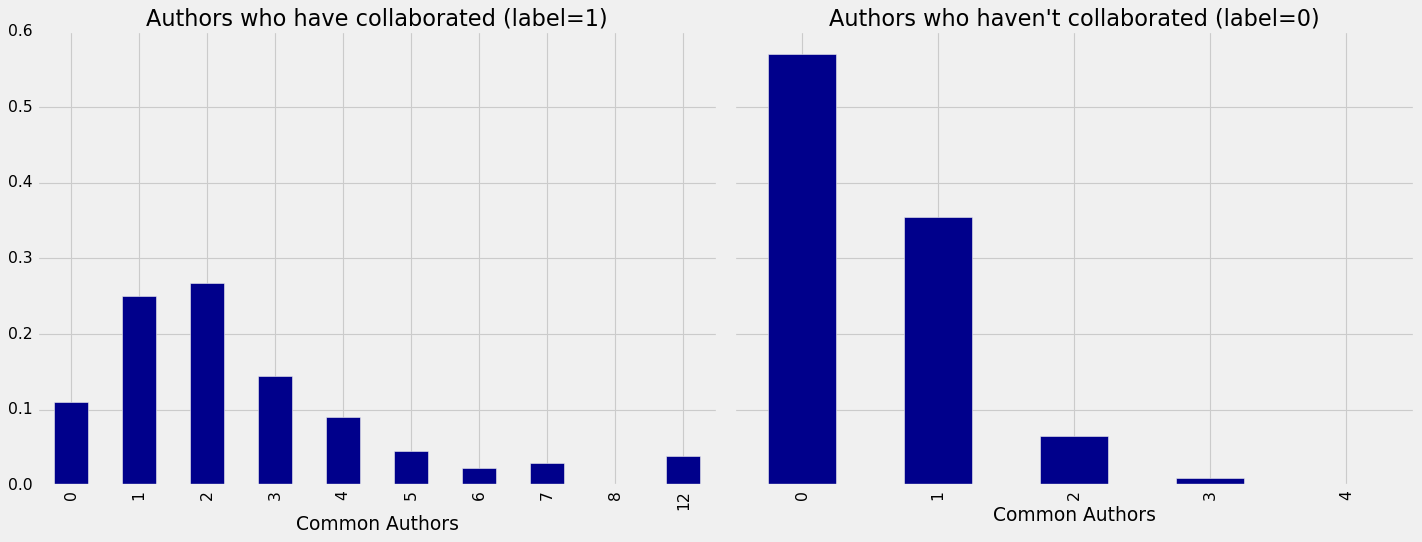

In [143]:
## frequency histogram of common authors
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]
for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    common_authors = filtered.toPandas()["commonAuthors"]
    histogram = common_authors.value_counts().sort_index()
    histogram /= float(histogram.sum())
    histogram.plot(kind="bar", x='Common Authors', color="darkblue",
    ax=axs[index], title=f"Authors who {title} (label={label})")
    axs[index].xaxis.set_label_text("Common Authors")
plt.tight_layout()
plt.show()

In [144]:
def train_model(fields, training_data):
    pipeline = create_pipeline(fields)
    model = pipeline.fit(training_data)
    return model

In [145]:
# model only uses co-authors
basic_model = train_model(["commonAuthors"], training_data)

In [146]:
eval_df = spark.createDataFrame(
    [(0,), (1,), (2,), (10,), (100,)],
    ['commonAuthors'])


In [147]:
eval_df.show(n=5)

+-------------+
|commonAuthors|
+-------------+
|            0|
|            1|
|            2|
|           10|
|          100|
+-------------+



In [148]:
(basic_model.transform(eval_df)
    .select("commonAuthors", "probability", "prediction")
    .show(truncate=False))

+-------------+----------------------------------------+----------+
|commonAuthors|probability                             |prediction|
+-------------+----------------------------------------+----------+
|0            |[0.7194646051065791,0.2805353948934209] |0.0       |
|1            |[0.7194646051065791,0.2805353948934209] |0.0       |
|2            |[0.10661158171528741,0.8933884182847126]|1.0       |
|10           |[0.10661158171528741,0.8933884182847126]|1.0       |
|100          |[0.10661158171528741,0.8933884182847126]|1.0       |
+-------------+----------------------------------------+----------+



In [149]:
def evaluate_model(model, test_data):
    # Execute the model against the test set
    predictions = model.transform(test_data)
    # Compute true positive, false positive, false negative counts
    tp = predictions[(predictions.label == 1) &
        (predictions.prediction == 1)].count()
    fp = predictions[(predictions.label == 0) &
        (predictions.prediction == 1)].count()
    fn = predictions[(predictions.label == 1) &
        (predictions.prediction == 0)].count()
    # Compute recall and precision manually
    recall = float(tp) / (tp + fn)
    precision = float(tp) / (tp + fp)
    # Compute accuracy using Spark MLLib's binary classification evaluator
    accuracy = BinaryClassificationEvaluator().evaluate(predictions)
    # Compute false positive rate and true positive rate using sklearn functions
    labels = [row["label"] for row in predictions.select("label").collect()]
    preds = [row["probability"][1] for row in predictions.select
    ("probability").collect()]
    fpr, tpr, threshold = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    return { "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc, "accuracy": accuracy,
        "recall": recall, "precision": precision }

In [150]:
def display_results(results):
    results = {k: v for k, v in results.items() if k not in
    ["fpr", "tpr", "roc_auc"]}
    return pd.DataFrame({"Measure": list(results.keys()), "Score": list(results.values())})

In [151]:
basic_results = evaluate_model(basic_model, test_data)
display_results(basic_results)

,Measure,Score
0,accuracy,0.839346
1,recall,0.719704
2,precision,0.946088


In [152]:
from cycler import cycler
def create_roc_plot():
    plt.style.use('classic')
    fig = plt.figure(figsize=(13, 8))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rc('axes', prop_cycle=(cycler('color',
    ['r', 'g', 'b', 'c', 'm', 'y', 'k'])))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random score (AUC = 0.50)')
    return plt, fig

In [153]:
def add_curve(plt, title, fpr, tpr, roc):
    plt.plot(fpr, tpr, label=f"{title} (AUC = {roc:0.2})")

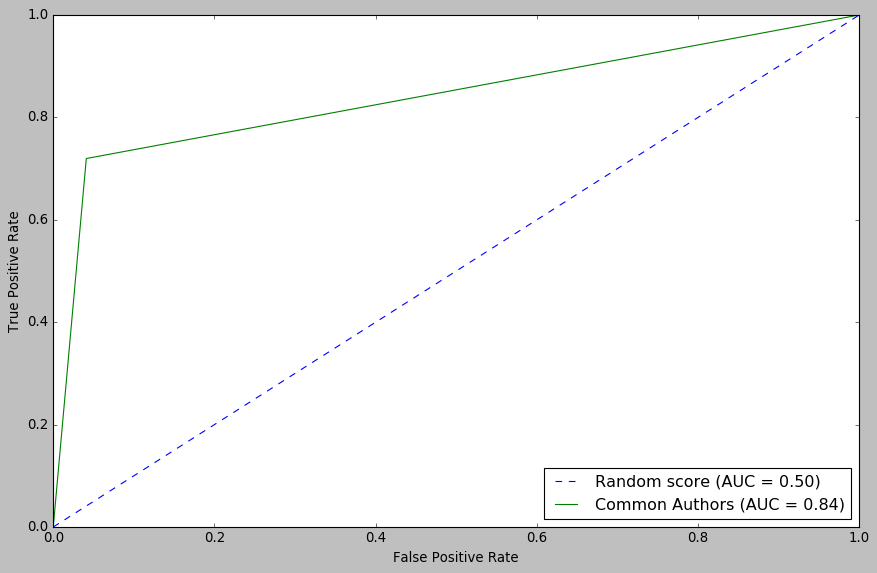

In [154]:
plt, fig = create_roc_plot()

add_curve(plt, "Common Authors",
basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])

plt.legend(loc='lower right')
plt.show()

In [155]:
(training_data.filter(training_data["label"]==1)
    .describe()
    .select("summary", "commonAuthors", "prefAttachment", "totalNeighbors")
    .show())

+-------+------------------+------------------+-----------------+
|summary|     commonAuthors|    prefAttachment|   totalNeighbors|
+-------+------------------+------------------+-----------------+
|  count|              2400|              2400|             2400|
|   mean|            2.6225|21.468333333333334|5.240833333333334|
| stddev|2.4911669715952045|33.848272351742274|2.889142424469169|
|    min|                 0|                 1|                2|
|    max|                12|               195|               16|
+-------+------------------+------------------+-----------------+



In [156]:
(training_data.filter(training_data["label"]==0)
    .describe()
    .select("summary", "commonAuthors", "prefAttachment", "totalNeighbors")
    .show())

+-------+------------------+------------------+------------------+
|summary|     commonAuthors|    prefAttachment|    totalNeighbors|
+-------+------------------+------------------+------------------+
|  count|              2400|              2400|              2400|
|   mean|0.5183333333333333|          12.50875|           4.48375|
| stddev|0.6713307736444628|16.816170291236347|2.5480269074914688|
|    min|                 0|                 1|                 1|
|    max|                 4|               225|                18|
+-------+------------------+------------------+------------------+



In [157]:
fields = ["commonAuthors", "prefAttachment", "totalNeighbors"]
graphy_model = train_model(fields, training_data)

In [158]:
graphy_results = evaluate_model(graphy_model, test_data)
display_results(graphy_results)

,Measure,Score
0,accuracy,0.975882
1,recall,0.928770
2,precision,0.941544


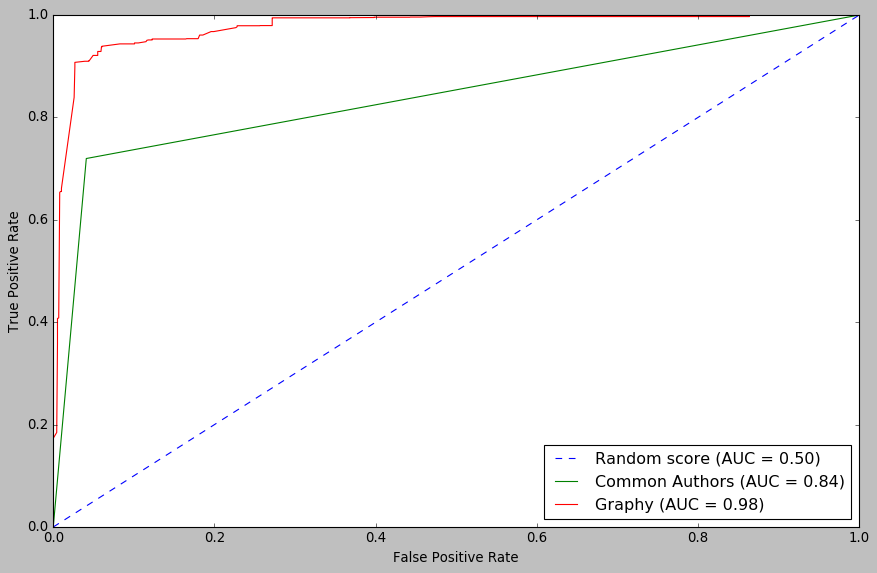

In [159]:
plt, fig = create_roc_plot()

add_curve(plt, "Common Authors",
    basic_results["fpr"], basic_results["tpr"],
    basic_results["roc_auc"])

add_curve(plt, "Graphy",
    graphy_results["fpr"], graphy_results["tpr"],
    graphy_results["roc_auc"])

plt.legend(loc='lower right')
plt.show()

In [160]:
def plot_feature_importance(fields, feature_importances):
    df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

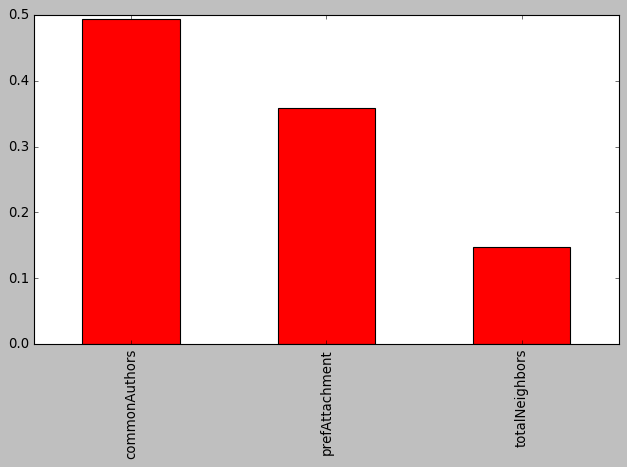

In [161]:
rf_model = graphy_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

## Triangles and clustering coefficient

https://neo4j.com/docs/graph-data-science/current/

https://neo4j.com/docs/graph-data-science/current/algorithms/triangle-count/

## Neo4j Graph Data Science Library

In order to run the algorithms as efficiently as possible, the Neo4j Graph Data Science library uses a specialized in-memory graph format to represent the graph data. It is therefore necessary to load the graph data from the Neo4j database into an in memory graph catalog. The amount of data loaded can be controlled by so called graph projections, which also allow, for example, filtering on node labels and relationship types, among other options

to see all algorithms
CALL gds.list()

algorithms are run using one of the execution modes stream, stats, mutate or write, which we cover in this chapter. 

The stream mode will return the results of the algorithm computation as Cypher result rows. This is similar to how standard Cypher reading queries operate. 

The stats mode returns statistical results for the algorithm computation like counts or percentile distributions. A statistical summary of the computation is returned as a single Cypher result row. The direct results of the algorithm are not available when using the stats mode. This mode forms the basis of the mutate and write execution modes but does not attempt to make any modifications or updates anywhere. 

The mutate mode will write the results of the algorithm computation back to the in-memory graph. Note that the specified mutateProperty value must not exist in the in-memory graph beforehand. This enables running multiple algorithms on the same in-memory graph without writing results to Neo4j in-between algorithm executions. 

The write mode will write the results of the algorithm computation back to the Neo4j database. This is similar to how standard Cypher writing queries operate. A statistical summary of the computation is returned similar to the stats mode. This is the only execution mode that will attempt to make modifications to the Neo4j database.

The written data can be node properties (such as Page Rank scores), new relationships (such as Node Similarity similarities), or relationship properties.


















In [162]:
# create a graph projection
graphdb.run("""CALL gds.graph.create('early_graph',
    'Author', 
    {
        CO_AUTHOR_EARLY: {
                type: 'CO_AUTHOR_EARLY',
                orientation: 'UNDIRECTED'
                }
                }
                )""")

In [163]:
graphdb.run("""CALL gds.graph.list""").evaluate()

'early_graph'

In [165]:
graphdb.run("""CALL gds.triangleCount.write.estimate('early_graph', { writeProperty: 'triangleCount' })
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory""").to_ndarray()

array([['4097', '4800', '32872', '32872', '32 KiB']], dtype='<U21')

In [167]:
#The Triangle Count algorithm in the GDS library only finds triangles in undirected graphs. 

graphdb.run("""CALL gds.triangleCount.write('early_graph', {
    writeProperty: 'triangles'
    })
    YIELD globalTriangleCount, nodeCount""").to_ndarray()


array([[2091, 4097]])

In [168]:
graphdb.run("""CALL gds.triangleCount.stream('early_graph')
    YIELD nodeId, triangleCount
    RETURN gds.util.asNode(nodeId).name AS name, triangleCount
    ORDER BY triangleCount DESC
    LIMIT 20;""").to_ndarray()

array([['Bastian Degener', '78'],
       ['Ingo Wegener', '78'],
       ['Patrick Briest', '78'],
       ['Thomas Jansen', '78'],
       ['Dirk Sudholt', '78'],
       ['Stefan Tannenbaum', '78'],
       ['Matthias Englert', '78'],
       ['Dimo Brockhoff', '78'],
       ['Christian Gunia', '78'],
       ['Oliver Heering', '78'],
       ['Kai Plociennik', '78'],
       ['Michael Leifhelm', '78'],
       ['Andrea Schweer', '78'],
       ['Heiko Röglin', '78'],
       ['Francis C. M. Lau', '39'],
       ['Cho-Li Wang', '34'],
       ['Yannis Tzitzikas', '29'],
       ['Panos Vassiliadis', '29'],
       ['Elisa Bertino', '28'],
       ['Stefano Rizzi', '28']], dtype='<U17')

In [169]:
graphdb.run("""CALL gds.localClusteringCoefficient.stream('early_graph')
    YIELD nodeId, localClusteringCoefficient
    RETURN gds.util.asNode(nodeId).name AS name, localClusteringCoefficient
    ORDER BY localClusteringCoefficient DESC
    LIMIT 10;""").to_ndarray()

array([['Pierre McKenzie', '1.0'],
       ['Hagen Völzer', '1.0'],
       ['Glynn Winskel', '1.0'],
       ['Clemens Lautemann', '1.0'],
       ['Yanchun Zhang', '1.0'],
       ['Daniele Varacca', '1.0'],
       ['Baoliu Ye', '1.0'],
       ['Yang Zhang', '1.0'],
       ['Heribert Vollmer', '1.0'],
       ['Thomas Schwentick', '1.0']], dtype='<U17')

In [170]:
# this is calculating triangles in background, you can make it use already calculated 
graphdb.run("""CALL gds.localClusteringCoefficient.write('early_graph', {
      writeProperty: 'localClusteringCoefficient'
    })
    YIELD averageClusteringCoefficient, nodeCount""").to_ndarray()

array([[3.06831672e-01, 4.09700000e+03]])

In [173]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]])
    AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]])
    AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]])
    AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]])
    AS maxCoefficient
    """
    params = {
    "pairs": [{"node1": row["node1"], "node2": row["node2"]}
    for row in data.collect()],
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = spark.createDataFrame(graphdb.run(query, params).to_data_frame())
    return data.join(features, ["node1", "node2"])

In [175]:
training_data = apply_triangles_features(training_data,
        "triangles", "localClusteringCoefficient")

In [176]:
training_data.show(n=5)

+-----+-----+-----+-------------+--------------+--------------+------------+------------+------------------+--------------+
|node1|node2|label|commonAuthors|prefAttachment|totalNeighbors|minTriangles|maxTriangles|    minCoefficient|maxCoefficient|
+-----+-----+-----+-------------+--------------+--------------+------------+------------+------------------+--------------+
|   15|   18|    1|            3|            24|             7|           6|          11|0.7333333333333333|           1.0|
|   87| 1227|    0|            1|             6|             4|           1|           3|               1.0|           1.0|
|  461|  462|    1|            6|            49|             8|          21|          21|               1.0|           1.0|
| 1571| 1574|    1|            4|            25|             6|          10|          10|               1.0|           1.0|
| 1574| 1577|    1|            4|            25|             6|          10|          10|               1.0|           1.0|
+-----+-

In [177]:
# create a graph projection
graphdb.run("""CALL gds.graph.create('late_graph',
    'Author', 
    {
        CO_AUTHOR_LATE: {
                type: 'CO_AUTHOR_LATE',
                orientation: 'UNDIRECTED'
                }
                }
                )""")

In [178]:
graphdb.run("""CALL gds.triangleCount.write('late_graph', {
    writeProperty: 'triangles'
    })
    YIELD globalTriangleCount, nodeCount""").to_ndarray()


array([[2813, 4097]])

In [179]:
# this is calculating triangles in background, you can make it use already calculated 
graphdb.run("""CALL gds.localClusteringCoefficient.write('late_graph', {
      writeProperty: 'localClusteringCoefficient'
    })
    YIELD averageClusteringCoefficient, nodeCount""").to_ndarray()

array([[4.29545184e-01, 4.09700000e+03]])

In [ ]:
#graphdb.run("""CALL gds.graph.drop('coauthor_graph');""")

In [180]:
test_data = apply_triangles_features(test_data,
        "triangles", "localClusteringCoefficient")

In [181]:
fields = ["commonAuthors", "prefAttachment", "totalNeighbors",
"minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient"]
triangle_model = train_model(fields, training_data)

In [182]:
triangle_results = evaluate_model(triangle_model, test_data)
display_results(triangle_results)

,Measure,Score
0,accuracy,0.993392
1,recall,0.986124
2,precision,0.960360


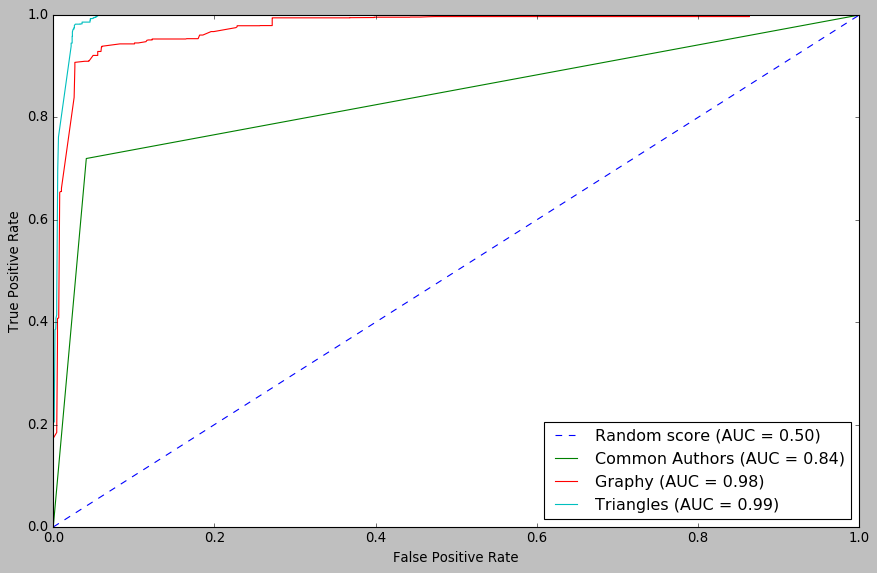

In [183]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",
basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "Graphy",
graphy_results["fpr"], graphy_results["tpr"],
graphy_results["roc_auc"])
add_curve(plt, "Triangles",
triangle_results["fpr"], triangle_results["tpr"],
triangle_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

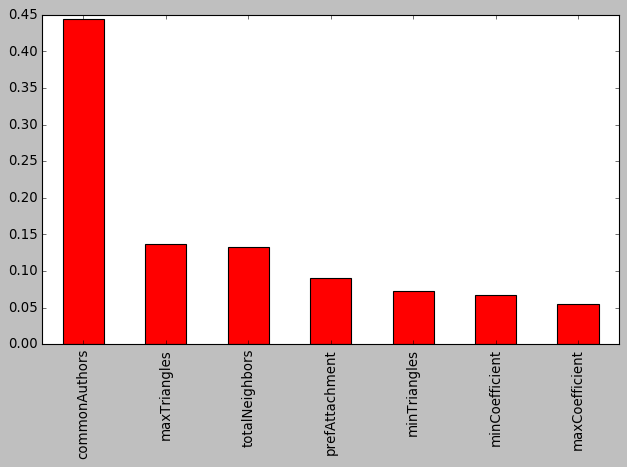

In [184]:
rf_model = triangle_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

## Community Detection

We’ll compute more coarse-grained communities using the **Label Propagation** algorithm in Neo4j.

https://neo4j.com/docs/graph-data-science/current/algorithms/label-propagation/

Running this algorithm requires sufficient memory availability. Before running this algorithm, we recommend that you read Section 3.1, “Memory Estimation”. 



In [188]:
graphdb.run("""CALL gds.labelPropagation.write.estimate('early_graph', { writeProperty: 'label' })
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory""").to_ndarray()

array([['4097', '4800', '34336', '558112', '[33 KiB ... 545 KiB]']],
      dtype='<U21')

In [197]:
graphdb.run("""CALL gds.labelPropagation.write('early_graph', { writeProperty: 'label' })
YIELD communityCount, ranIterations, didConverge""").to_ndarray()

array([[2837,    3,    1]])

**Louvain algorithm**

The Louvain method is an algorithm to detect communities in large networks. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities. This means evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network.

The Louvain algorithm is a hierarchical clustering algorithm, that recursively merges communities into a single node and executes the modularity clustering on the condensed graphs. 




In [194]:
graphdb.run("""CALL gds.louvain.write.estimate('early_graph', { writeProperty: 'community' })
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory""").to_ndarray()

array([['4097', '4800', '267689', '1624800', '[261 KiB ... 1586 KiB]']],
      dtype='<U22')

In [198]:
graphdb.run("""CALL gds.louvain.write('early_graph', { writeProperty: 'louvain' })
YIELD communityCount, modularity, modularities""").to_ndarray()

array([[2834, 0.9787923611111111,
        list([0.9481402777777778, 0.9787923611111111])]], dtype=object)

In [212]:
graphdb.run("""CALL gds.louvain.stream('early_graph',
{includeIntermediateCommunities:true})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
SET node.smallest = smallestCommunity""")

In [215]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    CASE WHEN p1[$partitionProp] = p2[$partitionProp] THEN
    1 ELSE 0 END AS samePartition,
    CASE WHEN p1[$louvainProp] = p2[$louvainProp] THEN
    1 ELSE 0 END AS sameLouvain
    """
    params = {
    "pairs": [{"node1": row["node1"], "node2": row["node2"]} for
    row in data.collect()],
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = spark.createDataFrame(graphdb.run(query, params).to_data_frame())
    return data.join(features, ["node1", "node2"])

In [216]:
training_data = apply_community_features(training_data,"label", "smallest")

In [217]:
training_data.show(n=5)

+-----+-----+-----+-------------+--------------+--------------+------------+------------+------------------+--------------+-------------+-----------+
|node1|node2|label|commonAuthors|prefAttachment|totalNeighbors|minTriangles|maxTriangles|    minCoefficient|maxCoefficient|samePartition|sameLouvain|
+-----+-----+-----+-------------+--------------+--------------+------------+------------+------------------+--------------+-------------+-----------+
|   15|   18|    1|            3|            24|             7|           6|          11|0.7333333333333333|           1.0|            1|          1|
|   87| 1227|    0|            1|             6|             4|           1|           3|               1.0|           1.0|            1|          0|
|  461|  462|    1|            6|            49|             8|          21|          21|               1.0|           1.0|            1|          1|
| 1571| 1574|    1|            4|            25|             6|          10|          10|           

In [219]:
graphdb.run("""CALL gds.labelPropagation.write('late_graph', { writeProperty: 'label' })
YIELD communityCount, ranIterations, didConverge""").to_ndarray()

array([[2473,    4,    1]])

In [218]:
graphdb.run("""CALL gds.louvain.stream('late_graph',
{includeIntermediateCommunities:true})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
SET node.smallest = smallestCommunity""")

In [220]:
test_data = apply_community_features(test_data,"label", "smallest")

In [221]:
test_data.show(n=5)

+-----+-----+-----+-------------+--------------+--------------+------------+------------+-------------------+-------------------+-------------+-----------+
|node1|node2|label|commonAuthors|prefAttachment|totalNeighbors|minTriangles|maxTriangles|     minCoefficient|     maxCoefficient|samePartition|sameLouvain|
+-----+-----+-----+-------------+--------------+--------------+------------+------------+-------------------+-------------------+-------------+-----------+
|   49| 3292|    0|            0|            18|             9|           3|          15|                1.0|                1.0|            1|          0|
|  173| 2802|    0|            1|             9|             5|           3|           3|                1.0|                1.0|            1|          0|
|  246|  249|    1|            1|             4|             3|           1|           1|                1.0|                1.0|            1|          1|
|  346|  346|    0|            0|            49|             7| 

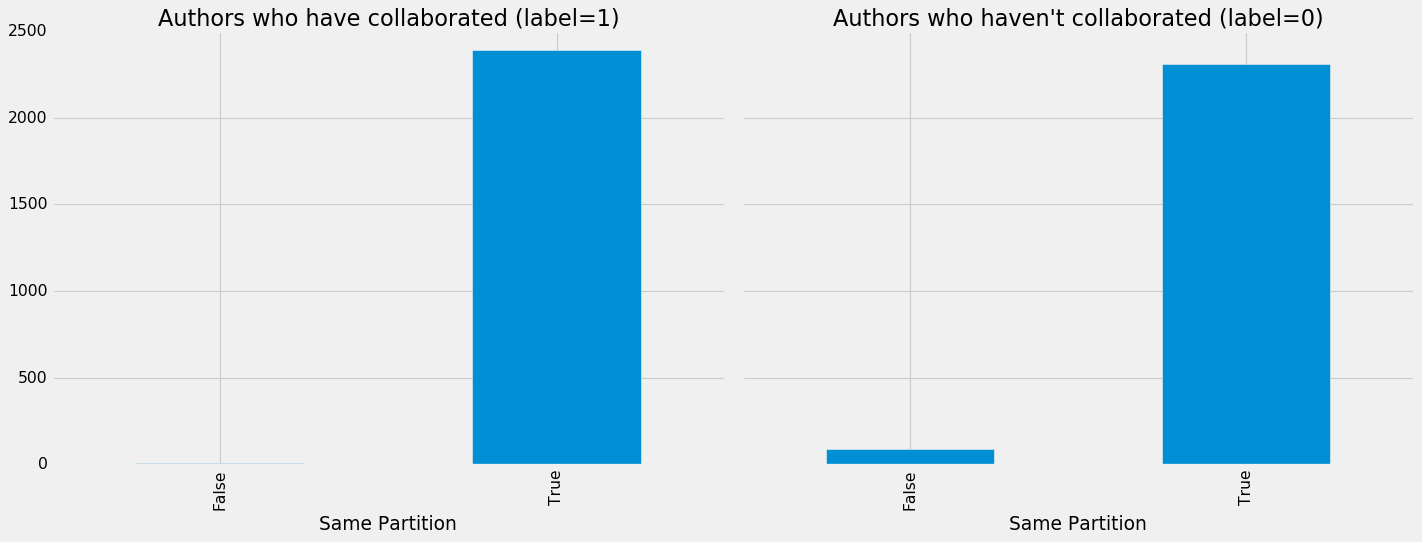

In [228]:
import pyspark.sql.functions as F

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    values = (filtered.withColumn('samePartition',F.when(F.col("samePartition") == 0, "False")
        .otherwise("True"))
        .groupby("samePartition")
        .agg(F.count("label").alias("count"))
        .select("samePartition", "count")
        .toPandas())
    values.set_index("samePartition", drop=True, inplace=True)
    values.plot(kind="bar", ax=axs[index], legend=None,
    title=f"Authors who {title} (label={label})")
    axs[index].xaxis.set_label_text("Same Partition")

plt.tight_layout()
plt.show()

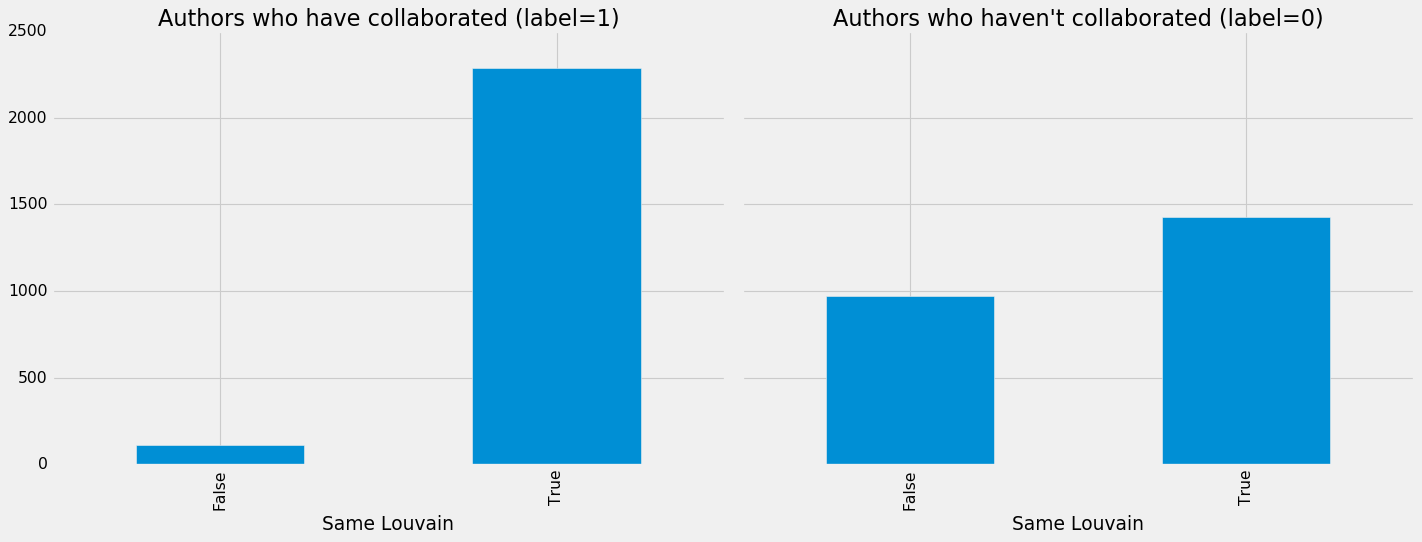

In [229]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]
for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    values = (filtered.withColumn('sameLouvain',
    F.when(F.col("sameLouvain") == 0, "False")
    .otherwise("True"))
    .groupby("sameLouvain")
    .agg(F.count("label").alias("count"))
    .select("sameLouvain", "count")
    .toPandas())
    values.set_index("sameLouvain", drop=True, inplace=True)
    values.plot(kind="bar", ax=axs[index], legend=None,
    title=f"Authors who {title} (label={label})")
    axs[index].xaxis.set_label_text("Same Louvain")

plt.tight_layout()
plt.show()

In [230]:
fields = ["commonAuthors", "prefAttachment", "totalNeighbors",
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient",
    "samePartition", "sameLouvain"]
community_model = train_model(fields, training_data)

In [231]:
community_results = evaluate_model(community_model, test_data)
display_results(community_results)

,Measure,Score
0,accuracy,0.996946
1,recall,0.989208
2,precision,0.982843


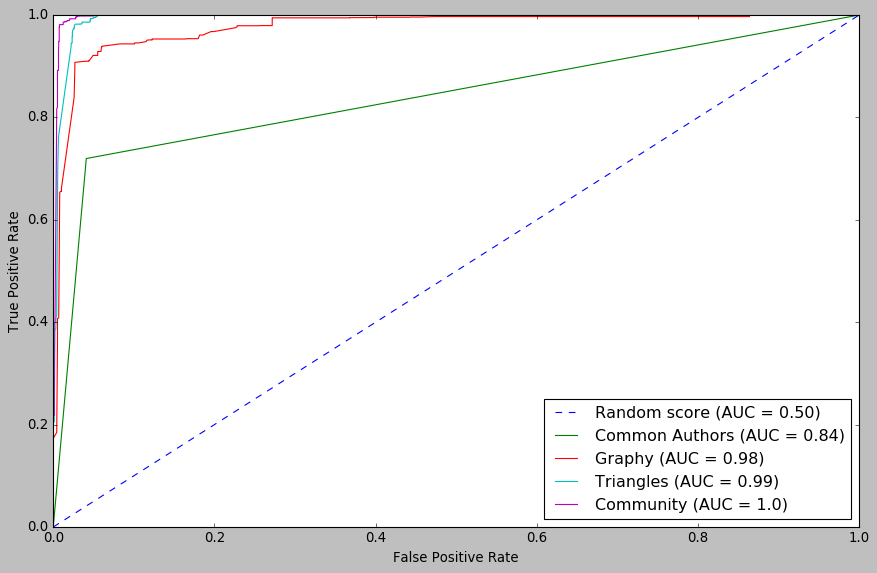

In [232]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",
basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "Graphy",
graphy_results["fpr"], graphy_results["tpr"],
graphy_results["roc_auc"])
add_curve(plt, "Triangles",
triangle_results["fpr"], triangle_results["tpr"],
triangle_results["roc_auc"])
add_curve(plt, "Community",
community_results["fpr"], community_results["tpr"],
community_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

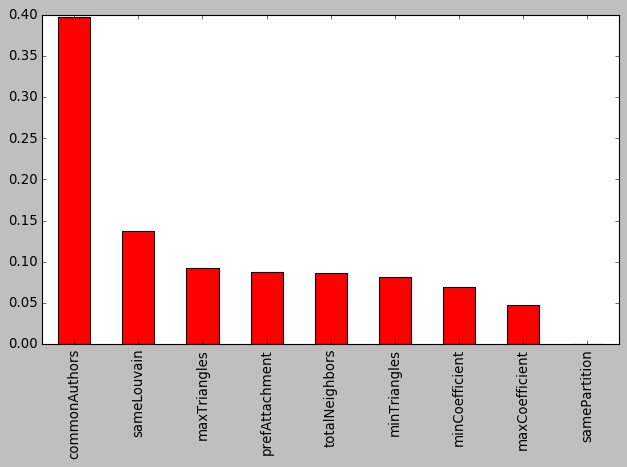

In [233]:
rf_model = community_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

https://towardsdatascience.com/learning-in-graphs-with-python-part-3-8d5513eef62d

In link prediction, we simply try to build a similarity measure between pairs of nodes and link the most similar nodes. The question is now to identify and compute the right similarity scores!

We can build several similarity scores for these two nodes based on their neighborhoods.

* Common Neighbors: S(i,j)=∣N(i)∩N(j)∣, i.e the number of common neighbors. In this example, the score would be simply 12, since they share only 2 common neighbors.

* Jaccard Coefficient: A normalized common neighbors version.

* Adamic-Adar index: For each common neighbor of nodes i and j, we add 1 divided by the total number of neighbors of that node. The concept is that common elements with very large neighborhoods are less significant when predicting a connection between two nodes compared to elements shared between a small number of nodes.

* Preferential attachment : S(i,j)=∣N(i,j)∣∗∣N(j)∣

* We can also use community information when it is available.


# Node2Vec Graph Embeddings 

https://towardsdatascience.com/node-embeddings-node2vec-with-neo4j-5152d3472d8e

Neo4j Graph Data Science library supports the random walk algorithm, which makes it very easy for us to implement the node2vec algorithm.

We will start by projecting the in-memory graph. We describe all three node labels and project relationships as undirected.

Now we are ready to train our first node2vec model. The process will consist of three parts:

    Execute the random walk algorithm starting from each node in the graph
    Feed the random walks to word2vec algorithm
    Inspect results by looking at the most similar neighbors

The random walk algorithm has an optional start parameter, which can be used to define the starting node of the walk. We can also specify how long the walk should be with the steps setting and how many times it should be repeated with the walks parameter. Note that every time random walk is executed, we expect a different result.

We will use the Word2vec algorithm implementation in the gensim library. It also has a couple of hyperparameters we can define. Most notable are:

    size: Dimensionality of the embedding vectors
    window: Maximum distance between the current and predicted word
    min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored.
    sg: The training algorithm: 1 for skip-gram; otherwise default CBOW
   
https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
    
Node2vec’s sampling strategy, accepts 4 arguments:
— Number of walks: Number of random walks to be generated from each node in the graph
— Walk length: How many nodes are in each random walk
— P: Return hyperparameter
— Q: Inout hyperaprameter
and also the standard skip-gram parameters (context window size, number of iterations etc.)

The algorithm for the random walk generation will go over each node in the graph and will generate <number of walks> random walks, of length <walk length>.
    
           
https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/random-walk/


https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf


http://snap.stanford.edu/node2vec/
    
    
https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/node2vec-link-prediction.html

Node2Vec first involves running random walks on the graph to obtain our context pairs, and using these to train a Word2Vec model.



https://radimrehurek.com/gensim/models/word2vec.html


https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

